In [1]:
import os
import sys
import pickle

from time import sleep
from time import time
from random import randint

import tensorflow as tf
import cv2
import numpy as np
#import mpld3

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.utils import shuffle

IMG_SIZE = (60, 60) # Size of image (e.g. 30x30) to be used as feature vector of length (e.g. 900x1)
NUM_CHANNELS = 1 # Grayscale
PIXEL_DEPTH = 255.0  # Number of levels per pixel.

### Dataset routines ###

In [2]:
def accuracy_func(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def make_feature_vec(img):
    """Resize an 'img' to correct size and 
    flatten rows x cols matrix to vector of rows ((60, 60) => (60, 60, 1))
    """
    if img.shape[:2] != IMG_SIZE:
        img = cv2.resize(img, IMG_SIZE)
    return normalize(img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))

def load_dataset(path, dataset_size=-1, downsample=False):
    """Loads samples from image files (e.g '001.png').
    Args:
        path -- path to the images(samples) (default size: 60px X 60px)
        dataset_size -- number of samples to read
        downsample -- downsamples input sample(img) if True
    Returns:
        images -- array (n, 60, 60, 1) of sample vectors as rows
    """
    image_files = os.listdir(path)[:dataset_size]
    # Init 'images' array as samples X features matrix
    images = np.ndarray(shape=(len(image_files), IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS), 
                        dtype=np.float32)
    image_idx = 0
    for filename in image_files:
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        if downsample:
            # Downsample image (scale down by 50%)
            img = cv2.pyrDown(img)
        if img.shape[:2] != IMG_SIZE:
            continue

        # Convert img matrix to proper format vector (n, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS)
        # Normalize (mean=0, stdev~=0.5)
        images[image_idx, :] = make_feature_vec(img)
        image_idx += 1
    return images

def label_dataset(pos_data, neg_data):
    """Prepare dataset. Combime pos and neg examples, label it & shuffle it.
    Args:
        pos_data -- array of positive samples
        neg_data -- array of negative samples
    Returns:
        dataset -- samples array
        labels -- labels vec
    """
    num_pos_samples = pos_data.shape[0]
    num_neg_samples = neg_data.shape[0] 
    num_total = num_pos_samples + num_neg_samples
    dataset = np.vstack((pos_data, neg_data[:num_neg_samples])).astype(np.float32)
    
    # Label as 1-hot encoding 
    # ex. np.array([1, 0], dtype=np.float32) -- positive
    # ex. np.array([0, 1], dtype=np.float32) -- negative
    
    num_classes = 2 # pos, neg
    labels = np.ndarray(shape=(num_total, num_classes), dtype=np.float32)
    labels[:num_pos_samples] = np.array([1, 0]) # positive
    labels[num_pos_samples:] = np.array([0, 1]) # negative
    
    # Shuffle
    return shuffle(dataset, labels, random_state=0)

def normalize(img):
    """Normalize to have approximately zero mean and standard deviation ~0.5 
    to make training easier down the road. 
    """
    mean = PIXEL_DEPTH / 2
    return (img - mean) / PIXEL_DEPTH

def preview(sample_vec):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.imshow(sample_vec.reshape(IMG_SIZE))
    
def preview_random_examples(pos_data, neg_data):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.figure(1)
    pos_idx = randint(1, len(pos_data))
    plt.title('POSITIVE (ex. #{})'.format(pos_idx))
    plt.imshow(pos_data[pos_idx].reshape(IMG_SIZE))

    plt.figure(2)
    neg_idx = randint(1, len(neg_data))
    plt.title('NEGATIVE (ex.#{})'.format(neg_idx))
    plt.imshow(neg_data[neg_idx].reshape(IMG_SIZE))
    plt.show()

### Load positive and negative examples from files into feature vectors ###

In [3]:
pos_path = './dataset/positive/'
neg_path = './dataset/negative/'
pos_data = load_dataset(path=pos_path)
neg_data = load_dataset(path=neg_path)
dataset, labels = label_dataset(pos_data, neg_data)

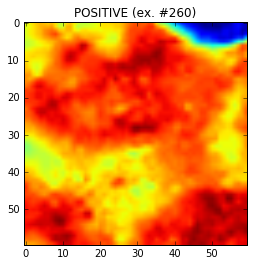

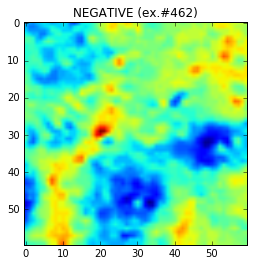

In [4]:
preview_random_examples(pos_data, neg_data)

### Spilt data to training, validation and test sets (60%, 20%, 20%) ###

In [5]:
idx_train = int(dataset.shape[0] * 0.6)
idx_cv = idx_train + int(dataset.shape[0] * 0.2)
train_dataset = dataset[:idx_train]
train_labels = labels[:idx_train]
valid_dataset = dataset[idx_train:idx_cv]
valid_labels = labels[idx_train:idx_cv]
test_dataset = dataset[idx_cv:]
test_labels = labels[idx_cv:]

print('No samples missed during spliting: {}'.format(len(labels) == len(train_labels) + len(valid_labels) + len(test_labels)))

No samples missed during spliting: True


### ============================================================= ###
### Train Convolutional Neural Network ###

In [16]:
### ConvNet with max pooling

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
log_dir = './log'
num_labels = 2

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, NUM_CHANNELS, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [IMG_SIZE[0] // 4 * IMG_SIZE[1] // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        shape = hidden.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer + LR decay.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100, 0.96) 
    # Get test set accuracy of 95.0%
    # (0.05, global_step, 1000, 0.96)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

[16, 15, 15, 16]
[670, 15, 15, 16]
[671, 15, 15, 16]


In [7]:
num_steps = 1001 #10001
acc_list = []

with tf.Session(graph=graph) as session:    
    tf.initialize_all_variables().run()
    print('Initialized')

    saver = tf.train.Saver()

    for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy_func(predictions, batch_labels))
        accuracy = accuracy_func(valid_prediction.eval(), valid_labels)
        print('Validation accuracy: %.1f%%' % accuracy)
        acc_list.append(accuracy)
    print('Test accuracy: %.1f%%' % accuracy_func(test_prediction.eval(), test_labels))
    
    # Save variables to file
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 0.551364
Minibatch accuracy: 87.5%
Validation accuracy: 19.1%
Minibatch loss at step 50: 0.328454
Minibatch accuracy: 75.0%
Validation accuracy: 80.9%
Minibatch loss at step 100: 0.376548
Minibatch accuracy: 87.5%
Validation accuracy: 92.7%
Minibatch loss at step 150: 0.197790
Minibatch accuracy: 100.0%
Validation accuracy: 82.4%
Minibatch loss at step 200: 0.149651
Minibatch accuracy: 93.8%
Validation accuracy: 93.3%
Minibatch loss at step 250: 0.138252
Minibatch accuracy: 100.0%
Validation accuracy: 93.9%
Minibatch loss at step 300: 0.261122
Minibatch accuracy: 87.5%
Validation accuracy: 95.4%
Minibatch loss at step 350: 0.141208
Minibatch accuracy: 93.8%
Validation accuracy: 91.0%
Minibatch loss at step 400: 0.084746
Minibatch accuracy: 100.0%
Validation accuracy: 93.7%
Minibatch loss at step 450: 0.292683
Minibatch accuracy: 93.8%
Validation accuracy: 94.8%
Minibatch loss at step 500: 0.059225
Minibatch accuracy: 100.0%
Validation accuracy: 95.

### Plot training curves ###

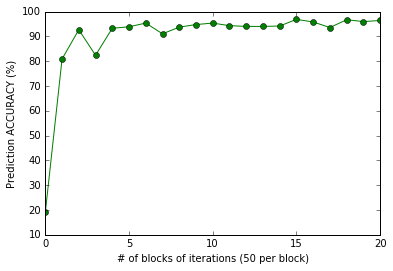

In [8]:
%matplotlib inline
plt.plot(acc_list, '-go')
plt.xlabel('# of blocks of iterations (50 per block)')
plt.ylabel('Prediction ACCURACY (%)')
plt.show()

### Save classifier ###

### ============================================================= ###
### Read clf from 'clf_tf.pickle' ###

### Visualize predicted samples ###

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]
Caused by op u'Variable/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/chip/Envs/bee_brood_counter/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-8abdcc28d60b>", line 23, in <module>
    [patch_size, patch_size, NUM_CHANNELS, depth], stddev=0.1))
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 195, in __init__
    name=name)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 242, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 436, in identity
    return _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/chip/Envs/bee_brood_counter/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()



Predicted positives visualization:


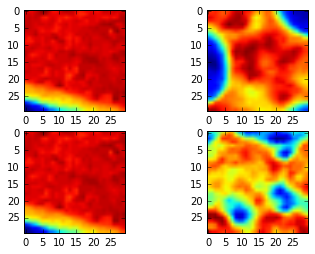

In [119]:
print('\nPredicted positives visualization:')

plt.subplot(221)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(222)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(223)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(224)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.show()

### ============================================================= ###
### Detect capped brood cells on WHOLE image ###
Use classifier on each single sample subimage, acquired with sliding window.
Remember to normalize before prediction!!!

In [89]:
def draw_rect(img, x, y, color):
    cv2.rectangle(img=img, 
                  pt1=(x, y), 
                  pt2=(x + WIN_SIZE, y + WIN_SIZE), 
                  color=color, 
                  thickness=2)
    return img
    
def draw_dot(img, x, y, color):
    cv2.putText(img=img, 
                text='.', 
                org=(x, y + IMG_SIZE[0]),        # TOP LEFT corner if bottomLeftOrigin=False
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=4, 
                color=color, 
                thickness=2, 
                bottomLeftOrigin=False)
    return img

def show(win_name, img):
    cv2.imshow(win_name, img)
    key_pressed = cv2.waitKey(1)
    return key_pressed

def sliding_window_to_feature_vec(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            window = image[y:y + windowSize[1], x:x + windowSize[0]]
            yield (x, y, np.array([ make_feature_vec(window) ]))

In [116]:
# Parameters
FILENAME = '003.png'
PATH = '/home/chip/Dropbox/LITS/ML-003/dataset/processed_dataset/prespective_correction'

WIN_SIZE = 55  # Will resize to 30px during processing
STEP = 50
PRED_THRESHOLD = 0.6
WIN_NAME = 'img'
VISUAL = False  # Visualize detection process (INCREASES RUNTIME)

In [117]:
img_path = os.path.join(PATH, FILENAME)
# Read GRAYSCALE img to predict on and COLOR one to show result
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_height, img_width = img.shape[:2]

# Create sliding window generator
samples_gen = sliding_window_to_feature_vec(image=img,
                                            stepSize = STEP,
                                            windowSize=(WIN_SIZE, WIN_SIZE))
cv2.namedWindow(WIN_NAME, cv2.WINDOW_NORMAL)
# Iterate through all the generated samples
for x, y, sample in samples_gen:
    if clf.predict_proba(sample)[0][1] > PRED_THRESHOLD:
    #if clf.decision_function(sample) > -0.2:
        draw_rect(img_rgb, x, y, (0, 255, 0))
    else:
        draw_dot(img_rgb, x, y, (0, 0, 255))
    if VISUAL:
        key = show(WIN_NAME, img_rgb)
        if key == ord('q'):
            break
while True:
    key = show(WIN_NAME, img_rgb)
    if key == ord('q'):
        break
cv2.destroyAllWindows()